In [1]:
from datasets import list_datasets

all_datasets = list_datasets()
print('현재 허브에는 {0}개의 데이터셋이 있습니다.'.format(len(all_datasets)))

c:\Users\aqs45\OneDrive\바탕 화면\repo\Transformers\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


현재 허브에는 20652개의 데이터셋이 있습니다.


In [2]:
from datasets import load_dataset

emotion = load_dataset('emotion') # emotion 데이터셋 로드
emotion

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/aqs45/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)
100%|██████████| 3/3 [00:00<00:00, 750.14it/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
train_ds = emotion['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [4]:
len(train_ds)

16000

In [5]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [6]:
train_ds.column_names

['text', 'label']

In [7]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [8]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [9]:
print(train_ds['text'][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


## 허브에 필요한 데이터셋이 없다면

이 책의 대부분 예제는 허깅페이스 허브를 사용해 데이터셋을 다운로드합니다. 하지만 많은 경우, 노트북 컴퓨터나 회사 원격 서버에 저장된 데이터를 사용해 작업합니다. 허깅페이스 데이터셋은 로컬 데이터셋이나 원격 데이터셋에 사용 가능한 로딩 스크립트를 몇 가지 제공합니다.

### 포맷에 따른 데이터셋 로딩 방법
* CSV : load_dataset('csv', data_files='my_file.csv')
* 텍스트 : load_dataset('text', data_files='my_file.txt')
* JSON : load_dataset('json', data_files='my_file.jsonl')

이렇게 데이터 포맷마다 `load_dataset()` 함수에 연관된 로딩 스크립트를 전달하고 data_files 매개변수에 `파일 경로`나 `URL`을 하나 이상 지정합니다.

In [10]:
import pandas as pd

emotion.set_format(type='pandas')
df = emotion['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [11]:
def label_int2str(row):
    return emotion['train'].features['label'].int2str(row) # int2str() 정수 레이블을 클래스 이름으로 바꿔줌

df['label_name'] = df['label'].apply(label_int2str) # apply() 특정 객체의 메소드를 적용
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


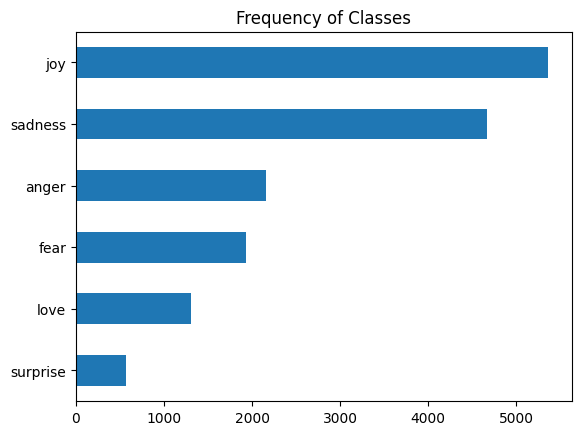

In [12]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes')
plt.show()


불균형한 데이터는 다음 방법으로 다룹니다.

* 소수 클래스를 랜덤하게 오버샘플링
* 다수 클래스를 랜덤하게 언더샘플링
* 클래스의 대표성이 부족하다면 레이블된 데이터를 더 많이 수집

## 트윗 길이 확인

트랜스포머 모델은 최대 문맥 크기(maximum context size)라는 최대 입력 시퀀스 길이가 있습니다. DistillBERT를 사용하는 애플리케이션에서 최대 문맥 크기는 512토큰으로 문단 몇 개 정도가 됩니다. 다음 절에서 보겠지만, 토큰은 `텍스트의 기본 단위`입니다. 여기서는 토큰을 단어로 간주하겠습니다. 트윗당 단어 분포를 보면 감정에 따른 트윗 길이가 대략 추정됩니다.

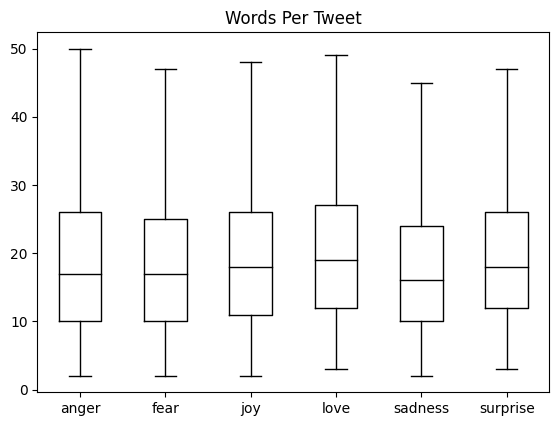

In [13]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot('Words Per Tweet', by='label_name', grid=False,
           color='black', showfliers=False,)  # showfliers : 아웃라이어는 표시하지 않음
plt.suptitle('')
plt.xlabel('')
plt.show()

In [14]:
emotion.reset_format() # dataFrane 포맷이 필요하지 않으니 데이터셋의 출력 포맷을 초기화

## 텍스트에서 토큰으로

DistillBERT 같은 트랜스포머 모델은 원시 문자열을 입력으로 받지 못합니다. 대신 텍스트가 토큰화되어 수치 벡터로 인코딩됐다고 가정해보죠. 토큰화는 문자열을 모델이 사용하는 기본 단위로 분할하는 단계입니다. 적용할 수 있는 토큰화 전략이 몇 가지 있으며 단어를 부분단위로 나누기 위한 최적 분할은 일반적으로 말뭉치에서 학습됩니다. 문자 토큰화와 단어 토큰화라는 극단적인 두 가지 방식을 살펴본 후 DistillBERT에서 사용하는 토크나이저에 대해 알아보겠습니다.

In [15]:
text = 'Tokenizing text is a core task of NLP.'
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [16]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [17]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [18]:
categorical_df = pd.DataFrame(
    {'Name' : ['Bumblebee', 'Optimus Prime', 'Megatron'], 'Label ID' : [0,1,2]}
)

categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [19]:
pd.get_dummies(categorical_df['Name'])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [20]:
import torch
import torch.nn.functional as F

input_ids = torch.Tensor(input_ids).to(torch.int64)
print(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape # 38개의 입력토큰 각각에 20차원의 원-핫 벡터 생성


tensor([ 5, 14, 12,  8, 13, 11, 19, 11, 13, 10,  0, 17,  8, 18, 17,  0, 11, 16,
         0,  6,  0,  7, 14, 15,  8,  0, 17,  6, 16, 12,  0, 14,  9,  0,  3,  2,
         4,  1])


torch.Size([38, 20])

In [21]:
print(f'토큰 : {tokenized_text[0]}')
print(f'텐서 인덱스: {input_ids[0]}')
print(f'원-핫 인코딩: {one_hot_encodings[0]}')

토큰 : T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


## 단어 토큰화

텍스트를 문자가 아니라 단어로 분할하고 각 단어를 정수로 매핑하겠습니다. 처음부터 단어를 사용하면 모델이 문자에서 단어를 학습하는 단계가 생략되어 훈련 과정의 복잡도가 감소합니다.

간단한 단어 토크나이저는 공백을 사용해 텍스트를 토큰화하는 것입니다. 원시 텍스트에 파이썬의 `split()` 함수를 적용하면 됩니다.

In [22]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


In [23]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

## AutoTokenizer

AutoTokenizer 클래스는 체크포인트 이름을 사용해 `모델의 설정`, `사전 훈련된 가중치`, `어휘사전`을 자동으로 추출하는 자동 클래스입니다. 이 클래스를 사용하면 모델 간의 빠른 전환이 가능하지만, 특정 클래스를 수동으로 로드할 수도 있습니다. 예를 들어 DistillBERT 토크나이저를 로드하는 방법은 다음과 같습니다.

In [24]:
from transformers import DistilBertTokenizer

distillbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [25]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [26]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)  # convert_ids_to_tokens 메서드를 사용해 다시 토큰으로 변환
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


여기서 세 가지 지점을 살펴보겠습니다. 먼저, `[CLS]`와 `[SEP]` 가 시퀀스 처음과 끝에 추가되었습니다. 이런 토큰은 모델마다 다르지만 주요 역할은 `시퀀스의 시작과 끝을 알리는것`입니다.

둘째, 토큰이 모두 소문자로 변환됐습니다. 이것이 이 체크포인트의 특징입니다.

마지막으로 `tokenizing`과 `NLP` 가 각각 두 개의 토큰으로 나뉘었습니다. 자주 등장하는 단어가 아니기 때문입니다. ##izing과 ##p에 있는 #는 앞의 문자열이 공백이 아님을 뜻합니다. 이런 접두사가 붙은 토큰은 문자열로 다시 바꿀 때 앞의 토큰과 합칩니다. AutoTokenizer 클래스는 이런 작업을 수행하는 `convert_tokens_to_string()` 메서드를 제공합니다. 앞의 토큰에 이 메서드를 적용해보죠

In [27]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [28]:
tokenizer.vocab_size # 어휘사전의 크기

30522

In [29]:
tokenizer.model_max_length # 모델의 최대 문맥 크기

512

In [30]:
tokenizer.model_input_names # 모델의 필드 이름

['input_ids', 'attention_mask']

## 전체 데이터셋 토큰화하기

전체 말뭉치를 토큰화하기 위해 DatasetDict 객체의 `map()` 메서드를 사용하겠습니다. 이 책에서는 데이터셋에 있는 각 원소에 어떤 처리 함수를 편리하게 적용하기 위해 map() 메서드를 많이 사용합니다. 곧 보겠지만, map() 메서드는 새 행과 열을 만드는데 사용할 수도 있습니다.

먼저 샘플을 토큰화할 처리 함수가 필요합니다.

In [31]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

* padding=True 배치에 있는 가장 긴 샘플 크기에 맞춰 샘플을 0으로 패딩

* truncation=True 모델의 최대 문맥 크기에 맞춰 샘플을 잘라냄

In [32]:
print(tokenize(emotion['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


패딩 결과를 보겠습니다. input_ids의 첫 번째 원소가 두 번쨰보다 더 짧으므로 길이를 동일하게 맞추기 위해 끝에 0을 추가했습니다. 0은 어휘사전에 있는 [PAD] 토큰에 해당합니다. 특수한 토큰은 앞서 본 [CLS]와 [SEP] 등입니다.

|특별한 토큰|[PAD]|[UNK]|[CLS]|[SEP]|[MASK]|
|---|---|---|---|---|---|
|특별한 토큰 ID|0|100|101|102|103|

토크나이저는 인코딩된 트윗을 input_ids로 반환하고, attention_mask 배열 리스트도 반환합니다. 추가된 패딩 토큰 때문에 모델이 혼동하지 않게 하려는 조치입니다.

![](./Static/%ED%99%94%EB%A9%B4%20%EC%BA%A1%EC%B2%98%202023-02-07%20143334.png)

In [33]:
emotions_encoded = emotion.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at C:\Users\aqs45\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-6316da5de5436960.arrow
Loading cached processed dataset at C:\Users\aqs45\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-2cb11f4abdb48d91.arrow
Loading cached processed dataset at C:\Users\aqs45\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-1983a40220248de7.arrow


기본적으로 `map()` 메서드는 말뭉치에 있는 모든 샘플에 개별적으로 작용하므로, batched=True로 설정하여 트윗을 배치로 인코딩하겠습니다.

batch_size=None 으로 설정했기 때문에 전체 데이터셋 하나의 배치로 tokenize() 함수에 적용됩니다. 이렇게 하면 입력 텐서와 어텐션 마스크는 전역적으로 동일한 크기로 생성됩니다. 또 이 연산은 데이터셋에 input_ids와 attention_mask 열을 새로 추가합니다.

In [34]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [35]:
print(emotions_encoded)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})


## 텍스트 분류 모델 훈련하기

DistillBERT 같은 모델은 텍스트 시퀀스에 있는 마스킹된 단어를 예측하도록 사전 훈련합니다. 하지만 이런 언어 모델을 바로 텍스트 분류에 사용하지는 못합니다. 약간의 수정이 필요합니다.

![](./Static/143813.png)

In [36]:
from transformers import AutoModel
import torch

model_ckpt = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_ckpt).to(device)

c:\Users\aqs45\OneDrive\바탕 화면\repo\Transformers\venv\lib\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aqs45\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_

## 마지막 은닉 상태 추출하기

하나의 문자열에 대한 마지막 은닉 상태를 추출하는 것으로 시작해보죠. 우선 문자열을 인코딩하고 토큰을 파이토치 텐서로 변환합니다. 토크나이저에 return_tensors='pt' 매개변수를 지정해 이 작업을 수행합니다.

In [38]:
text = 'this is a test'
inputs = tokenizer(text, return_tensors='pt')
print(f"입력 텐서 크기 : {inputs['input_ids'].size()}") # 텐서 결과의 크기는 [batch_size, n_tokens]

입력 텐서 크기 : torch.Size([1, 6])


In [39]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [41]:
outputs.last_hidden_state.size() # [batch_size, n_tokens, hidden_dim]

torch.Size([1, 6, 768])

In [42]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [43]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
    if k in tokenizer.model_input_names}

    # 마지막 은닉 상태 추출
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    
    # [CLS] 토큰에 대한 벡터 반환
    return {'hidden_state': last_hidden_state[:,:0].cpu().numpy()}

In [44]:
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [47]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

  0%|          | 0/16 [00:00<?, ?ba/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB (GPU 0; 4.00 GiB total capacity; 3.24 GiB already allocated; 0 bytes free; 3.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [46]:
print(device)

cuda
